# EmoNeXt

The code below was adopted from the EmoNeXt repository outlined below. However the code was used as is in only with minor changes as major code alterations affected the output, thus the repository needs to be downloaded and added under the directory EmoNeXt-master.

**LINK**: https://github.com/yelboudouri/EmoNeXt

## EmoNeXt Training

In [ ]:
# Define your variables
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned' 
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned'
dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned'

batch_size = 32
learning_rate = 0.00001
epochs = 300
patience = 15
num_workers = 0
model_size = ["tiny", "small", "base", "large", "xlarge"][1]
output_dir = "ModelsReadyForComparison"
use_amp = True # Use Mixed Precision
use_22k = True # Use 22k model (larger model)
checkpoint = "" #"ModelsReadyForComparison/EmoNeXt_AffectNet_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True_old.pt" # Path to the checkpoint file

# Construct the %run command
run_command = f"EmoNeXt-master/train.py --dataset-name={dataset_name} --dataset-path={data_directory} --batch-size={batch_size} --patience={patience} --lr={learning_rate} --epochs={epochs} --num-workers={num_workers} --model-size={model_size} --output-dir={output_dir}"

# Add the --amp flag if use_amp is True
run_command += " --amp" if use_amp else ""

# Add the --in_22k flag if use_22k is True
run_command += " --in_22k" if use_22k else ""

run_command += f" --checkpoint {checkpoint}" if checkpoint != "" else ""

print(run_command)
# Execute the command
%run {run_command}

## EmoNeXt Testing

In [1]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from ema_pytorch import EMA
import importlib  
models = importlib.import_module("EmoNeXt-master.models")

from torch.utils.data import ConcatDataset

def TestEmoNeXt(data_directory, model_path, base_model_size='small', base_model_in_22k=False, batch_size=15, dataset=['test'], ignored_labels=[]):

    ema_decay = 0.99  # Default unchanged values
    ema_update_every = 16  # Default unchanged values

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    # Transform the dataset
    transform = transforms.Compose(
        [
            transforms.Grayscale(),  # Convert image to grayscale if needed
            transforms.Resize(236),  # Resize the image
            transforms.TenCrop(224),  # Apply ten-cropping (10 different crops)
            transforms.Lambda(
                lambda crops: torch.stack(
                    [transforms.ToTensor()(crop) for crop in crops]
                )
            ),  # Convert each crop to tensor
            transforms.Lambda(
                lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
            ),
        ]
    )

    state_dict = torch.load(model_path, weights_only=True)

    final_fc_layer = [k for k in state_dict['model'].keys() if 'head' in k and 'weight' in k][-1]
    num_classes = state_dict['model'][final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    model = models.get_model(num_classes, base_model_size, base_model_in_22k) 
    model.load_state_dict(state_dict['model'], strict=False) 
    model.eval()

    ema_model = EMA(model, beta=ema_decay, update_every=ema_update_every).to(device)
    ema_model.load_state_dict(state_dict["ema"], strict=False)
    ema_model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    test_dataset = []
    for ds in dataset:
        dataset_part = datasets.ImageFolder(f'{data_directory}/{ds}', transform=transform)  
        test_dataset.append(dataset_part)
    test_dataset = ConcatDataset(test_dataset)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)

    # Define the valid labels (those that exist in the test set)
    valid_labels_set = set(range(num_classes))  # Assuming model is trained with a range from 0 to num_classes-1

    cnt = 0
    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            print(cnt, '/', len(test_loader))
            cnt += 1
            inputs, labels = data[0].to(device), data[1].to(device)

            # Skip images with ignored labels
            mask = ~np.isin(labels.cpu().numpy(), ignored_labels)  # Move labels to CPU before numpy operations
            if mask.sum() == 0:
                continue  # Skip this batch entirely if all labels are in ignored_labels
            inputs = inputs[mask].to(device)
            labels = labels[mask].to(device)

            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)   

            # Forward pass through the ema_model
            _, logits = ema_model(inputs)
            
            # Reshape logits back to (batch_size, ncrops, num_classes) and average over crops
            outputs_avg = logits.view(bs, ncrops, -1).mean(1)

            # Calculate softmax probabilities
            probs = F.softmax(outputs_avg, dim=1)
            all_probs.append(probs.cpu().numpy())

            # Get the predictions
            predictions = torch.argmax(outputs_avg, dim=1)

            # Replace invalid predictions with the next highest valid prediction
            fixed_preds = []
            for i, pred in enumerate(predictions.cpu().numpy()):
                if pred not in valid_labels_set:  # Check if the prediction is valid
                    sorted_indices = np.argsort(all_probs[i])[::-1]  # Sort predictions by probability (descending)
                    for pred_idx in sorted_indices:
                        if pred_idx in valid_labels_set:  # Check if the predicted class is valid
                            fixed_preds.append(pred_idx)
                            break
                else:
                    fixed_preds.append(pred)

            all_preds.append(fixed_preds)
            all_labels.append(labels.cpu().numpy())  # Move labels to CPU before numpy operations

    # Concatenate lists to form single arrays
    all_preds = np.concatenate([pred for pred in all_preds])  # Move preds to CPU before numpy operations
    all_labels = np.concatenate([label for label in all_labels])  # Move labels to CPU before numpy operations

    print("All Labels: ", all_labels)
    print("(B4 Mapping) All Predictions: ", all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=list(valid_labels_set))

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)

    # Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### Deriving Metrics across all datasets

Using cuda device
Number of classes: 7
0 / 48
1 / 48
2 / 48
3 / 48
4 / 48
5 / 48
6 / 48
7 / 48
8 / 48
9 / 48
10 / 48
11 / 48
12 / 48
13 / 48
14 / 48
15 / 48
16 / 48
17 / 48
18 / 48
19 / 48
20 / 48
21 / 48
22 / 48
23 / 48
24 / 48
25 / 48
26 / 48
27 / 48
28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48
All Labels:  [0 0 0 ... 6 6 6]
(B4 Mapping) All Predictions:  [0 0 0 ... 6 2 2]
Test Accuracy: 0.6414602346805737
Precision (Weighted): 0.7190473860320967
Precision (Macro): 0.5400214370674047
Precision (Micro): 0.6414602346805737
Recall (Weighted): 0.6414602346805737
Recall (Macro): 0.5235637801157942
Recall (Micro): 0.6414602346805737
F1 Score (Weighted): 0.6617793528213286
F1 Score (Macro): 0.5037036090137431
F1 Score (Micro): 0.6414602346805737

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.77      0.55        81


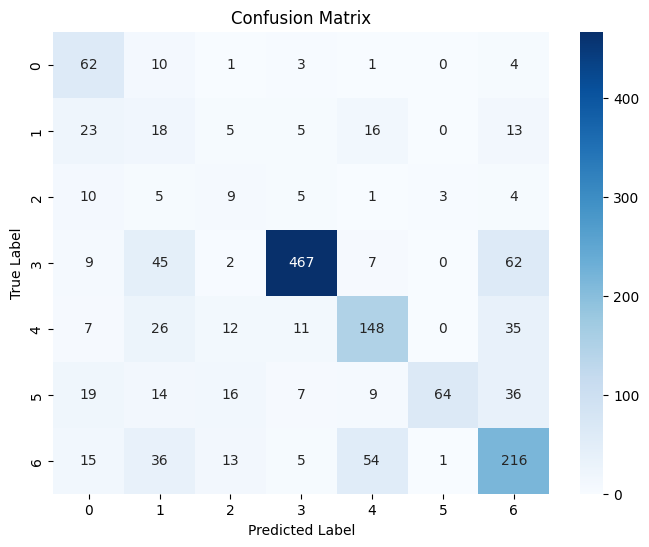

In [16]:
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'

model_path = 'ModelsReadyForComparison/EmoNeXt_FER_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'

base_model_size = 'small'
base_model_in_22k = True

TestEmoNeXt(data_directory, model_path, base_model_size, base_model_in_22k, batch_size=32, ignored_labels=[7])

Using cuda device
Number of classes: 7
0 / 113
1 / 113
2 / 113
3 / 113
4 / 113
5 / 113
6 / 113
7 / 113
8 / 113
9 / 113
10 / 113
11 / 113
12 / 113
13 / 113
14 / 113
15 / 113
16 / 113
17 / 113
18 / 113
19 / 113
20 / 113
21 / 113
22 / 113
23 / 113
24 / 113
25 / 113
26 / 113
27 / 113
28 / 113
29 / 113
30 / 113
31 / 113
32 / 113
33 / 113
34 / 113
35 / 113
36 / 113
37 / 113
38 / 113
39 / 113
40 / 113
41 / 113
42 / 113
43 / 113
44 / 113
45 / 113
46 / 113
47 / 113
48 / 113
49 / 113
50 / 113
51 / 113
52 / 113
53 / 113
54 / 113
55 / 113
56 / 113
57 / 113
58 / 113
59 / 113
60 / 113
61 / 113
62 / 113
63 / 113
64 / 113
65 / 113
66 / 113
67 / 113
68 / 113
69 / 113
70 / 113
71 / 113
72 / 113
73 / 113
74 / 113
75 / 113
76 / 113
77 / 113
78 / 113
79 / 113
80 / 113
81 / 113
82 / 113
83 / 113
84 / 113
85 / 113
86 / 113
87 / 113
88 / 113
89 / 113
90 / 113
91 / 113
92 / 113
93 / 113
94 / 113
95 / 113
96 / 113
97 / 113
98 / 113
99 / 113
100 / 113
101 / 113
102 / 113
103 / 113
104 / 113
105 / 113
106 / 113
1

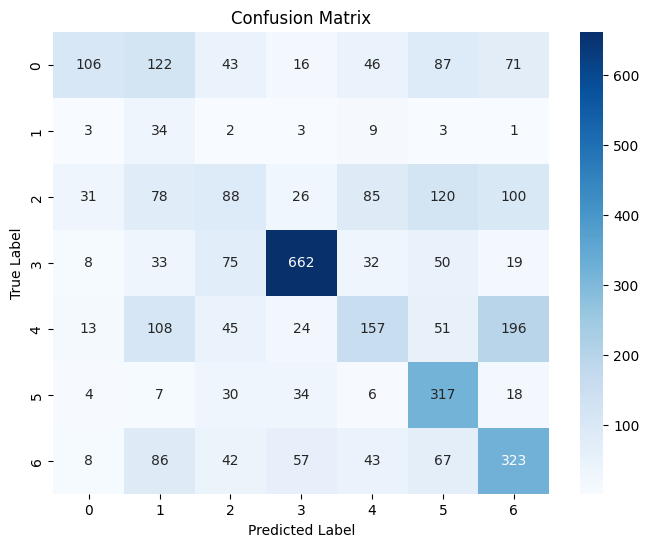

In [15]:
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
# data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'

model_path = 'ModelsReadyForComparison/EmoNeXt_RAF-DB_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'

base_model_size = 'small'
base_model_in_22k = True

TestEmoNeXt(data_directory, model_path, base_model_size, base_model_in_22k, batch_size=32)

Using cuda device
Number of classes: 8
0 / 48
1 / 48
2 / 48
3 / 48
4 / 48
5 / 48
6 / 48
7 / 48
8 / 48
9 / 48
10 / 48
11 / 48
12 / 48
13 / 48
14 / 48
15 / 48
16 / 48
17 / 48
18 / 48
19 / 48
20 / 48
21 / 48
22 / 48
23 / 48
24 / 48
25 / 48
26 / 48
27 / 48
28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48
All Labels:  [0 0 0 ... 6 6 6]
(B4 Mapping) All Predictions:  [0 0 0 ... 6 4 1]
Test Accuracy: 0.6349413298565841
Precision (Weighted): 0.7792489409045521
Precision (Macro): 0.5003500538233481
Precision (Micro): 0.6349413298565841
Recall (Weighted): 0.6349413298565841
Recall (Macro): 0.5566284392746776
Recall (Micro): 0.6349413298565841
F1 Score (Weighted): 0.6818218799704373
F1 Score (Macro): 0.49118064404493356
F1 Score (Micro): 0.6349413298565841

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.73      0.48        81

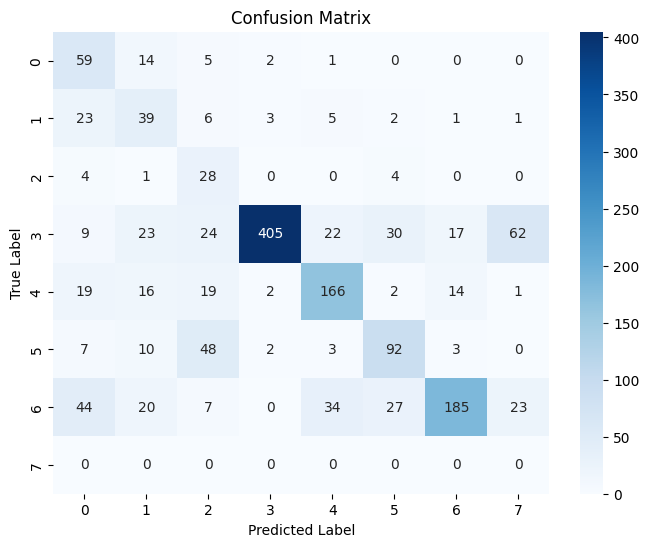

In [14]:
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/CK+_Structured_Aligned'

model_path = 'ModelsReadyForComparison/EmoNeXt_AffectNet_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'

base_model_size = 'small'
base_model_in_22k = True

TestEmoNeXt(data_directory, model_path, base_model_size, base_model_in_22k, batch_size=32, ignored_labels=[7])